In [15]:
import numpy as np

import matplotlib.pyplot as plt

from data import utm_data_generator as utm_dg_lib
from data import utms as utms_lib

In [16]:
seed=1

batch_size = 10000
# Using the paper's parameters
sequence_length = 256
memory_size = 200
max_steps = 1000
maximum_program_length = 200

def generate_programs(with_markov: bool = False):
    rng = np.random.default_rng(seed)
    program_sampler = utms_lib.FastSampler(rng=rng)
    utm = utms_lib.BrainPhoqueUTM(program_sampler, shorten_program=True)
    data_generator = utm_dg_lib.UTMDataGenerator(
        batch_size=batch_size,
        seq_length=sequence_length,
        rng=rng,
        utm=utm,
        memory_size=memory_size,
        maximum_steps=max_steps,
        tokenizer=utm_dg_lib.Tokenizer.ASCII,
        maximum_program_length=maximum_program_length,
    )

    params = data_generator.sample_params(sample_size=data_generator.batch_size, with_markov=with_markov)
    sequences, categorical_probs, extra = data_generator.sample_from_params(params=params)

    short_programs = extra['short_programs']

    log_dict = {
        "categorical_probs": categorical_probs,
        "params": params,
    }
    log_dict.update(extra)

    return short_programs, sequences

short_programs, sequences = generate_programs()
short_programs_with_markov, sequences_with_markov = generate_programs(with_markov=True)

Average length of short programs: 23.62


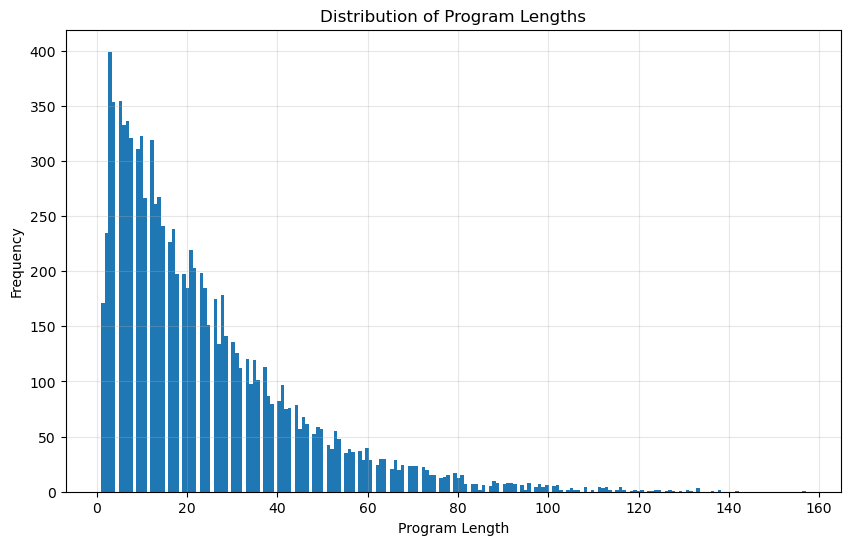

Average length of short programs: 66.50


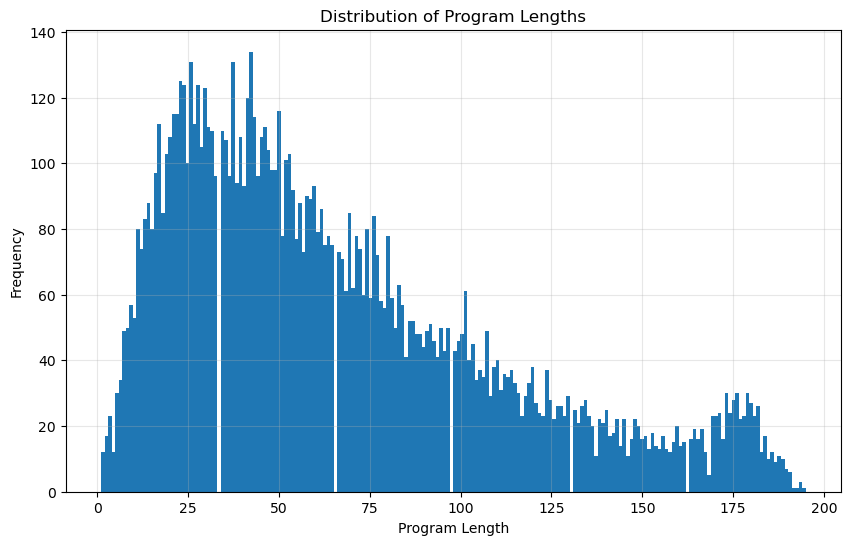

In [17]:
def analyze_program_lengths(short_programs: list):
    # average length of the short programs
    avg_length = sum(len(program) for program in short_programs) / len(short_programs)
    print(f"Average length of short programs: {avg_length:.2f}")

    # histogram of the lengths of programs vs occurrences
    program_lengths = [len(program) for program in short_programs]
    plt.figure(figsize=(10, 6))
    plt.hist(program_lengths, bins=200, alpha=1)
    plt.xlabel('Program Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Program Lengths')
    plt.grid(True, alpha=0.3)
    plt.show()

analyze_program_lengths(short_programs)
analyze_program_lengths(short_programs_with_markov)

============Without markov============
Average effective sequence length: 62.03


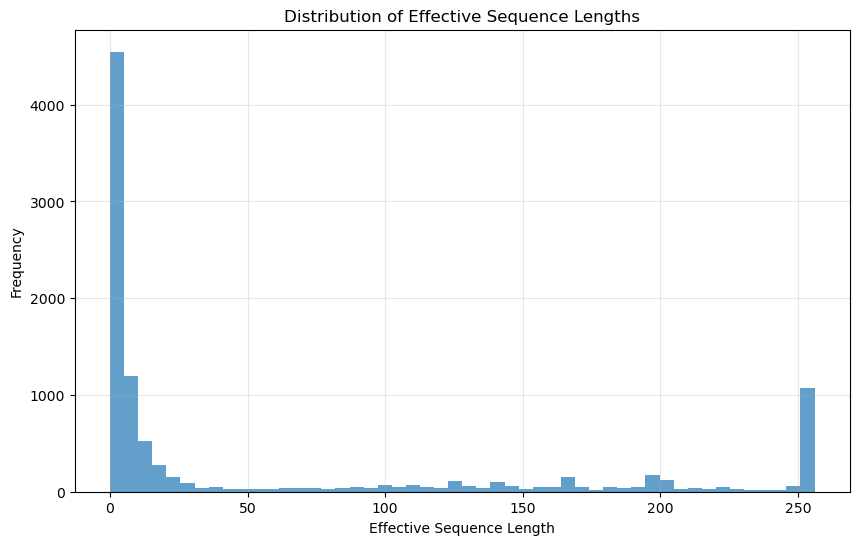

============With markov============
Average effective sequence length: 178.74


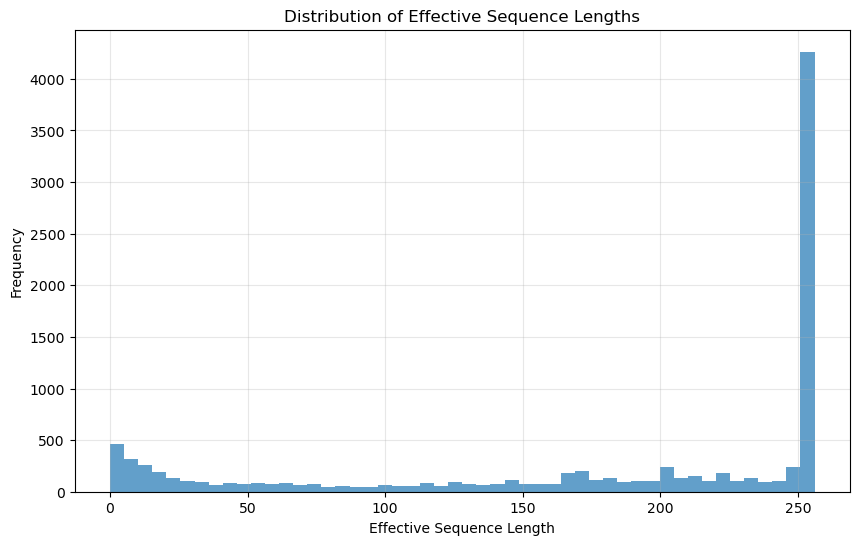

In [18]:
def analyze_interesting_sequences(sequences: list):
    # Find the index at which trailing zeros start in each sequence
    # This helps identify the actual content length vs padding
    sequence_lengths = []
    for sequence in sequences:
        # Convert one-hot encoding to indices
        indices = np.argmax(sequence, axis=1)
        
        # Find the last non-zero index (if any)
        non_zero_indices = np.where(indices != 0)[0]
        if len(non_zero_indices) > 0:
            # The actual sequence length is the position of the last non-zero token + 1
            sequence_length = non_zero_indices[-1] + 1
        else:
            # If all zeros, the effective length is 0
            sequence_length = 0
            
        sequence_lengths.append(sequence_length)
    
    # Calculate statistics
    avg_sequence_length = sum(sequence_lengths) / len(sequence_lengths)
    print(f"Average effective sequence length: {avg_sequence_length:.2f}")
    
    # Plot the distribution of sequence lengths
    plt.figure(figsize=(10, 6))
    plt.hist(sequence_lengths, bins=50, alpha=0.7)
    plt.xlabel('Effective Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Effective Sequence Lengths')
    plt.grid(True, alpha=0.3)
    plt.show()

print("============Without markov============")
analyze_interesting_sequences(sequences)
print("============With markov============")
analyze_interesting_sequences(sequences_with_markov)

Average program length (Without Markov): 23.62
Average program length (With Markov): 66.50
Median program length (Without Markov): 18.0
Median program length (With Markov): 55.0


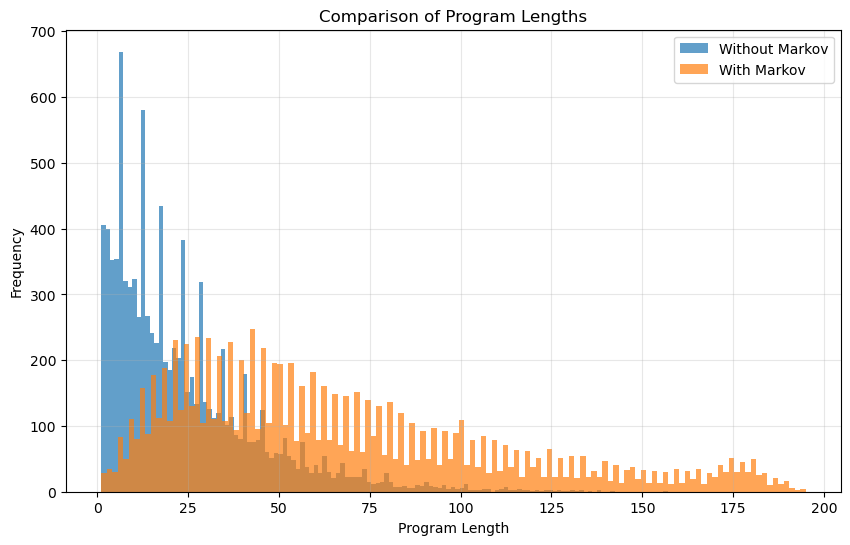

In [19]:
def compare_program_lengths(programs1, programs2, label1="Without Markov", label2="With Markov"):
    # Calculate program lengths for both datasets
    def get_program_lengths(programs):
        return [len(program) for program in programs]
    
    lengths1 = get_program_lengths(programs1)
    lengths2 = get_program_lengths(programs2)
    
    # Calculate statistics
    avg_length1 = sum(lengths1) / len(lengths1)
    avg_length2 = sum(lengths2) / len(lengths2)
    
    print(f"Average program length ({label1}): {avg_length1:.2f}")
    print(f"Average program length ({label2}): {avg_length2:.2f}")
    print(f"Median program length ({label1}): {np.median(lengths1)}")
    print(f"Median program length ({label2}): {np.median(lengths2)}")
    
    # Plot the distributions side by side
    plt.figure(figsize=(10, 6))
    
    # Create a histogram with transparency
    plt.hist(lengths1, bins=128, alpha=0.7, label=label1)
    plt.hist(lengths2, bins=128, alpha=0.7, label=label2)
    
    plt.xlabel('Program Length')
    plt.ylabel('Frequency')
    plt.title('Comparison of Program Lengths')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Compare the program lengths between the two datasets
compare_program_lengths(short_programs, short_programs_with_markov)


Average effective sequence length (Without Markov): 62.03
Average effective sequence length (With Markov): 178.74
Median effective sequence length (Without Markov): 7.0
Median effective sequence length (With Markov): 224.0


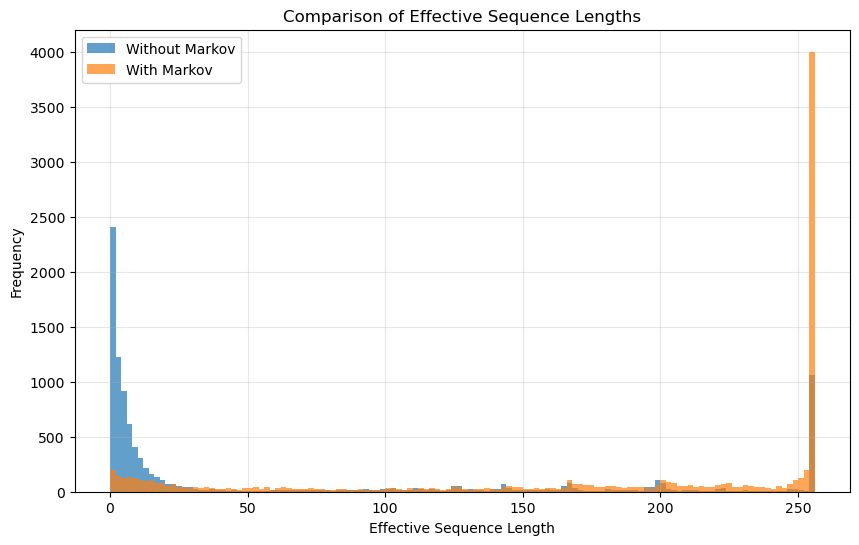

In [20]:
def compare_sequence_lengths(sequences1, sequences2, label1="Without Markov", label2="With Markov"):
    # Calculate sequence lengths for both datasets
    def get_sequence_lengths(sequences):
        sequence_lengths = []
        for sequence in sequences:
            # Convert one-hot encoding to indices
            indices = np.argmax(sequence, axis=1)
            
            # Find the last non-zero index (if any)
            non_zero_indices = np.where(indices != 0)[0]
            if len(non_zero_indices) > 0:
                # The actual sequence length is the position of the last non-zero token + 1
                sequence_length = non_zero_indices[-1] + 1
            else:
                # If all zeros, the effective length is 0
                sequence_length = 0
                
            sequence_lengths.append(sequence_length)
        return sequence_lengths
    
    lengths1 = get_sequence_lengths(sequences1)
    lengths2 = get_sequence_lengths(sequences2)
    
    # Calculate statistics
    avg_length1 = sum(lengths1) / len(lengths1)
    avg_length2 = sum(lengths2) / len(lengths2)
    
    print(f"Average effective sequence length ({label1}): {avg_length1:.2f}")
    print(f"Average effective sequence length ({label2}): {avg_length2:.2f}")
    print(f"Median effective sequence length ({label1}): {np.median(lengths1)}")
    print(f"Median effective sequence length ({label2}): {np.median(lengths2)}")

    # Plot the distributions side by side
    plt.figure(figsize=(10, 6))
    
    # Create a histogram with transparency
    plt.hist(lengths1, bins=128, alpha=0.7, label=label1)
    plt.hist(lengths2, bins=128, alpha=0.7, label=label2)
    
    plt.xlabel('Effective Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Comparison of Effective Sequence Lengths')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Compare the sequence lengths between the two datasets
compare_sequence_lengths(sequences, sequences_with_markov)
